# MPS using the deesse wrapper - simulations using multiple TIs

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
geone version: 1.2.4


## Training images (TIs)
The training images are read from the files `ti.txt` and `ti4.txt`. Both images have *one* variable of the same nature, but depicting different kinds of patterns.

**Note:** to clarify the terminology, we say that we work with *two* TIs having *one* variable (or property) of the same nature.

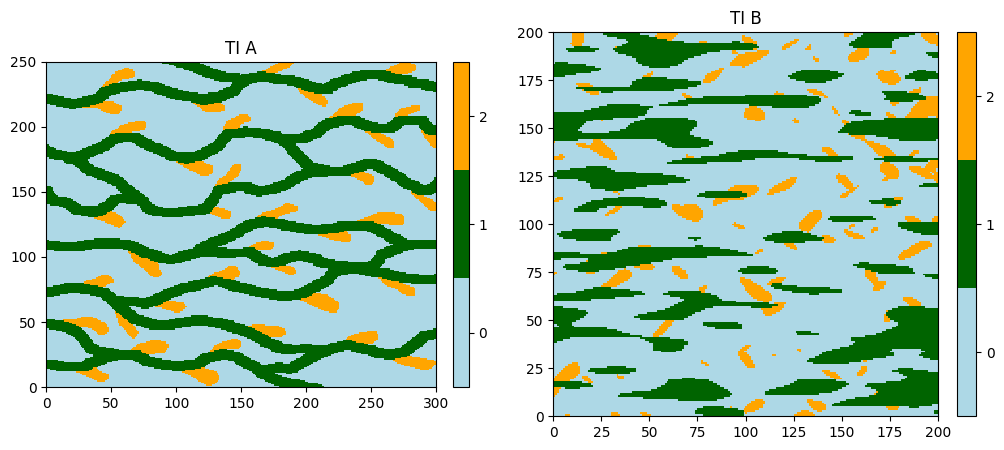

In [3]:
# Read files
data_dir = 'data'
tiA = gn.img.readImageTxt(os.path.join(data_dir, 'ti.txt'))
tiB = gn.img.readImageTxt(os.path.join(data_dir, 'ti4.txt'))

# Define category values and colors
categ_val = [0, 1, 2]
categ_col = ['lightblue', 'darkgreen', 'orange']

# Figure
plt.subplots(1,2, figsize=(12,5))

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(tiA, categ=True, categVal=categ_val, categCol=categ_col, title='TI A')

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(tiB, categ=True, categVal=categ_val, categCol=categ_col, title='TI B')

plt.show()

## Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [4]:
nx, ny, nz = 480, 180, 1    # number of cells
sx, sy, sz = 1.0, 1.0, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin (corner of the "first" grid cell)

## Probability of TI selection
To perform a deesse simulation with multiple TIs, one needs to give for each simulation grid cell the probability to select each of the TI considered. When a cell is simulated, a TI is first selected randomly according to these probabilties in that cell, and then it is scanned. 

Below, a piece of python code to build:
- `pdf_ti`: (`nTI`, `nz`, `ny`, `nx`)-array containing probability values to select each of the TI on the simulation grid (here `nTI` = 2)

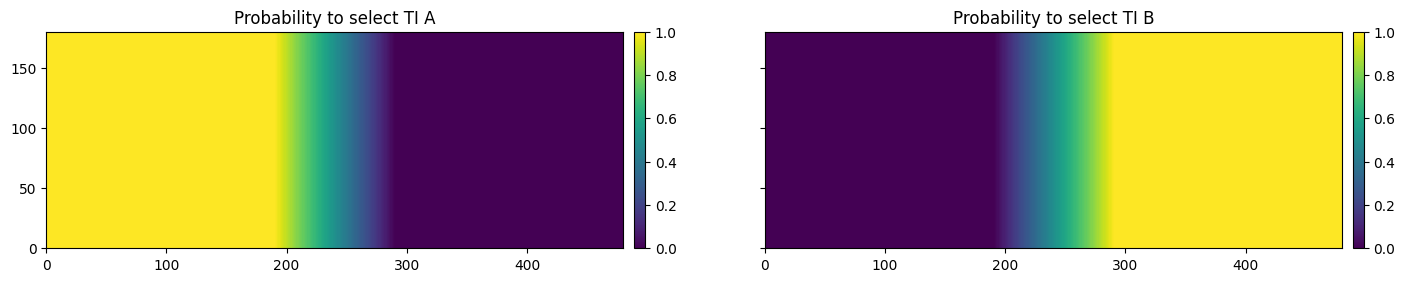

In [5]:
# Set an image with simulation grid geometry defined above, and no variable
im = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Get the x and y coordinates of the centers of grid cell (meshgrid)
xx = im.xx()[0]
yy = im.yy()[0]

# Equivalent:
## xg, yg: coordinates of the centers of grid cell
#xg = ox + 0.5*sx + sx*np.arange(nx)
#yg = oy + 0.5*sy + sy*np.arange(ny)
#xx, yy = np.meshgrid(xg, yg) # create meshgrid from the center of grid cells

# Number of TIs
nTI = 2

# Define probability to select TI B
pB = (np.minimum(np.maximum(xx, 190), 290) - 190) / 100
# Define probability to select TI A
pA = 1.0 - pB

pdf_ti = np.zeros((nTI, nz, ny, nx))
pdf_ti[0,0,:,:] = pA
pdf_ti[1,0,:,:] = pB

# Set variables pA and pB in image im
im.append_var(pdf_ti, varname=['pA', 'pB'])

# Display
plt.subplots(1,2, figsize=(17,5), sharey=True) # 1 x 2 sub-plots

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(im, iv=0, title='Probability to select TI A')

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(im, iv=1, title='Probability to select TI B')

plt.show()

## Fill the input structure for deesse and launch deesse

In [6]:
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=[tiA, tiB],           # list of TIs
    pdfTI=pdf_ti,            # set probability of TI selection
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=[0.25, 0.3],  # set maximal scanned fraction for each TI (list of length 'nTI')
    npostProcessingPathMax=1,
    seed=444,
    nrealization=1)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
DeeSse run complete
Elapsed time: 1.1 sec


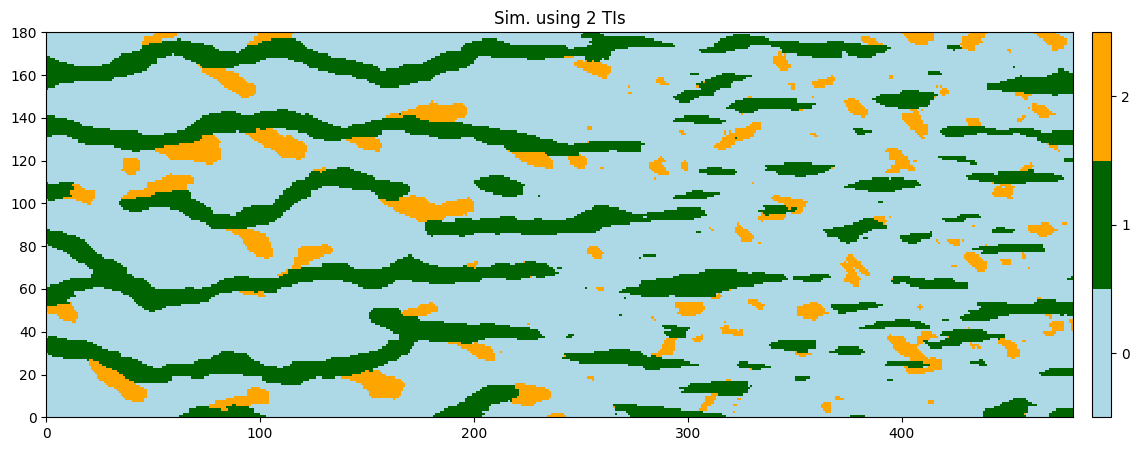

In [7]:
# Retrieve the results
sim = deesse_output['sim']

# Display
plt.figure(figsize=(16,5))
gn.imgplot.drawImage2D(sim[0], categ=True, categVal=categ_val, categCol=categ_col, title='Sim. using 2 TIs')
plt.show()